In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = mls
band = 7
commitnumber = 043bdfe
conc = None
dv = 0.001
klin = 2e-24
molecule = h2o
ng_adju = [0]
ng_refs = [7]
nv = 1000
option_compute_btable = 0
option_compute_ktable = 0
option_wgt_flux = 1
option_wgt_k = 1
ref_pts = [(600, 250)]
tsfc = 294
vmax = 1380
vmin = 1215
w_diffuse = [(2, 1.6, 1.6, 1.6, 1.6, 1.6, 1.8)]
wgt = [(0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.9)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

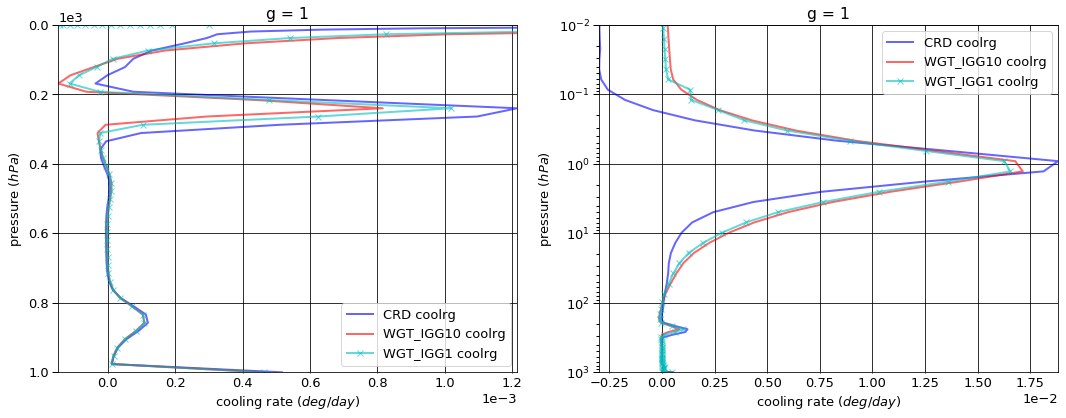

# Figure: cooling rate g-group 2

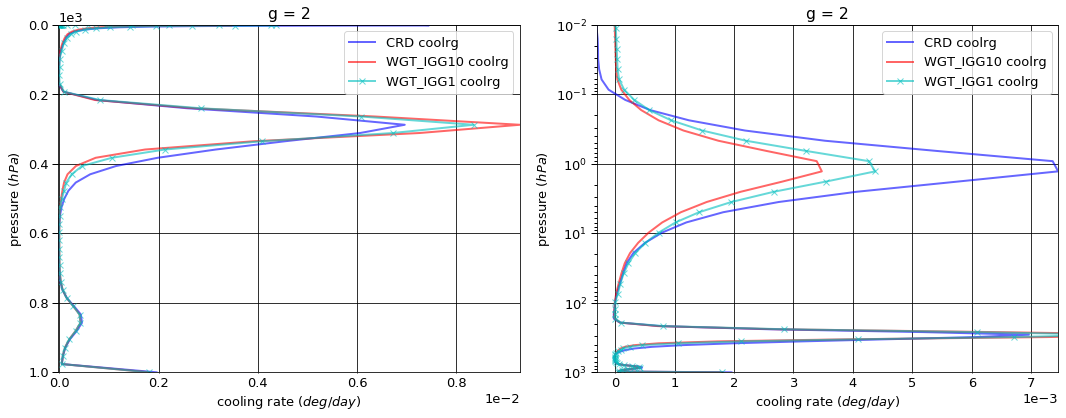

# Figure: cooling rate g-group 3

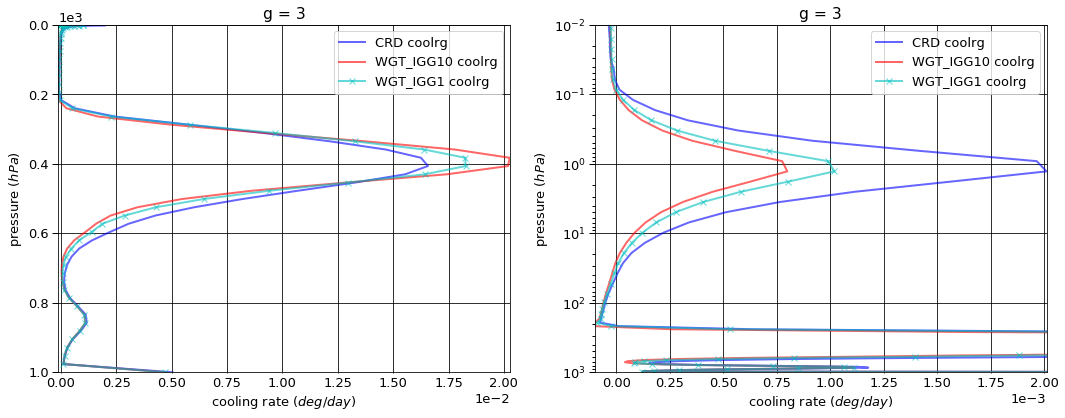

# Figure: cooling rate g-group 4

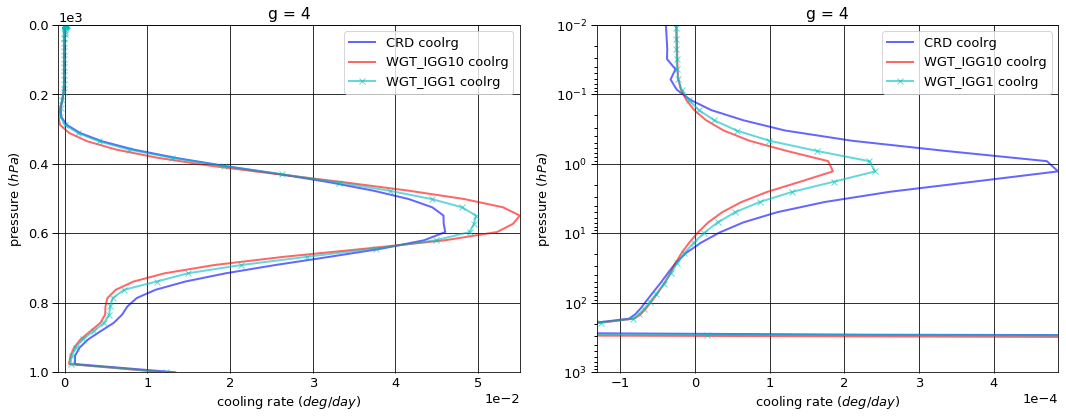

# Figure: cooling rate g-group 5

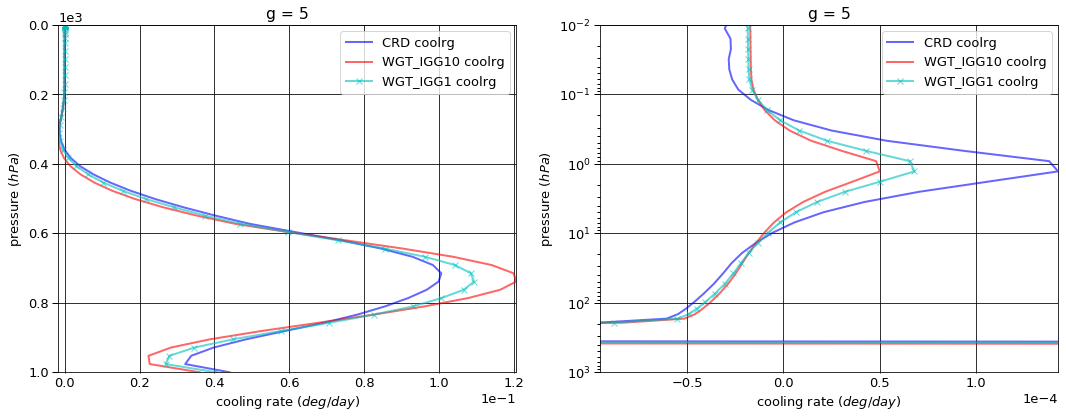

# Figure: cooling rate g-group 6

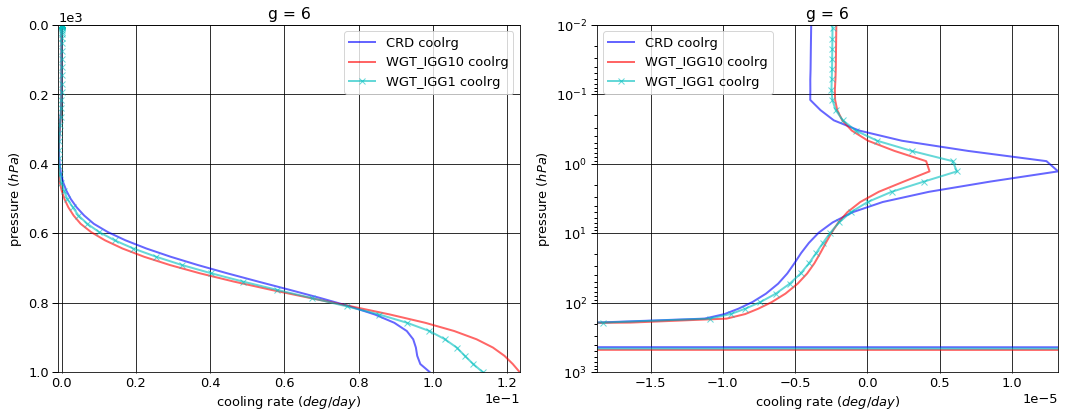

# Figure: cooling rate g-group 7

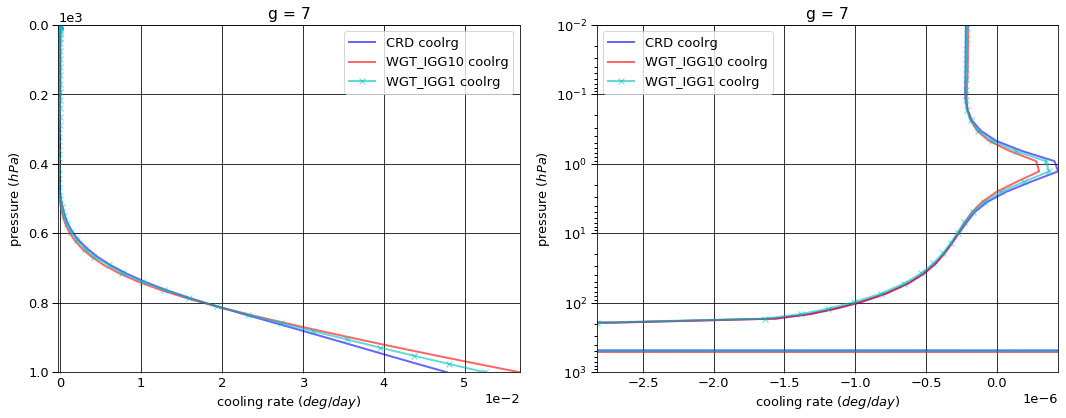

# Figure: cooling rate g-group total

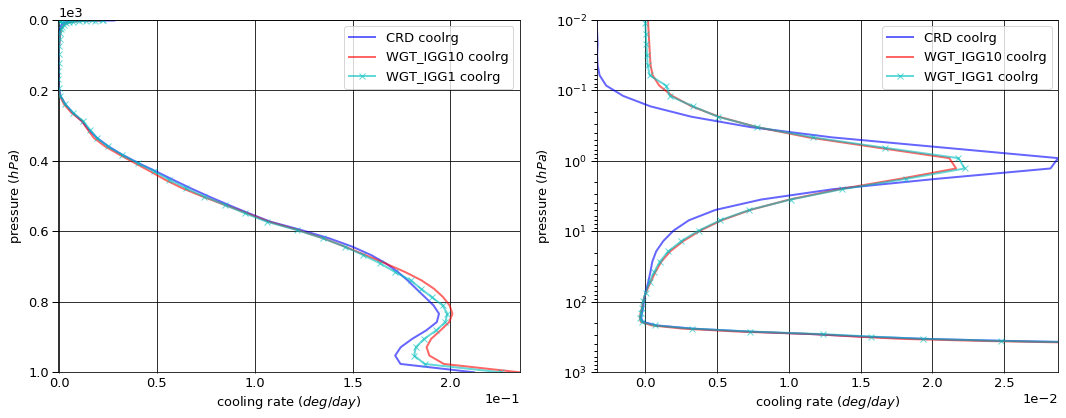

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.022793  0.000000 -0.022793
  1013.0   76    -0.156490  0.155040 -0.001450
2 0.0      1     -0.116106  0.000000 -0.116106
  1013.0   76    -0.599713  0.594226 -0.005487
3 0.0      1     -0.451273  0.000000 -0.451273
  1013.0   76    -1.557239  1.543098 -0.014140
4 0.0      1     -1.739189  0.000000 -1.739189
  1013.0   76    -3.947341  3.908950 -0.038391
5 0.0      1     -4.383456  0.000000 -4.383456
  1013.0   76    -6.923455  6.690463 -0.232992
6 0.0      1     -5.291379  0.000000 -5.291379
  1013.0   76    -6.260172  4.325878 -1.934294
7 0.0      1     -4.103785  0.000000 -4.103785
  1013.0   76    -4.310766  1.244837 -3.065929


WGT_IGG10


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.022245  0.000000 -0.022245
  1013.0   76    -0.147439  0.146141 -0.001298
2 0.0      1     -0.112863  0.000000 -0.112863
  1013.0   76    -0.573687  0.568636 -0.005051
3 0.0      1     -0.441003  0.000000 -0.441003
  1013.0   76    -1.503222  1.489986 -0.013236
4 0.0      1     -1.703366  0.000000 -1.703366
  1013.0   76    -3.822803  3.788844 -0.033960
5 0.0      1     -4.367150  0.000000 -4.367150
  1013.0   76    -6.839046  6.694936 -0.144110
6 0.0      1     -5.488943  0.000000 -5.488943
  1013.0   76    -6.389044  4.452577 -1.936467
7 0.0      1     -4.268157  0.000000 -4.268157
  1013.0   76    -4.479934  1.325103 -3.154831


WGT_IGG1


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.022768  0.000000 -0.022768
  1013.0   76    -0.147439  0.146141 -0.001298
2 0.0      1     -0.112961  0.000000 -0.112961
  1013.0   76    -0.573687  0.568636 -0.005051
3 0.0      1     -0.441180  0.000000 -0.441180
  1013.0   76    -1.503222  1.489986 -0.013236
4 0.0      1     -1.700832  0.000000 -1.700832
  1013.0   76    -3.822803  3.788382 -0.034422
5 0.0      1     -4.352971  0.000000 -4.352971
  1013.0   76    -6.839046  6.677688 -0.161359
6 0.0      1     -5.444191  0.000000 -5.444191
  1013.0   76    -6.389044  4.393223 -1.995821
7 0.0      1     -4.264003  0.000000 -4.264003
  1013.0   76    -4.479934  1.296221 -3.183713


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.000548  0.000000  0.000548
  1013.0   76     0.009052 -0.008900  0.000152
2 0.0      1      0.003243  0.000000  0.003243
  1013.0   76     0.026025 -0.025590  0.000435
3 0.0      1      0.010270  0.000000  0.010270
  1013.0   76     0.054017 -0.053112  0.000905
4 0.0      1      0.035823  0.000000  0.035823
  1013.0   76     0.124538 -0.120107  0.004431
5 0.0      1      0.016306  0.000000  0.016306
  1013.0   76     0.084408  0.004474  0.088882
6 0.0      1     -0.197564  0.000000 -0.197564
  1013.0   76    -0.128872  0.126699 -0.002173
7 0.0      1     -0.164373  0.000000 -0.164373
  1013.0   76    -0.169168  0.080266 -0.088901


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1      0.000025  0.000000  0.000025
  1013.0   76     0.009052 -0.008900  0.000152
2 0.0      1      0.003145  0.000000  0.003145
  1013.0   76     0.026025 -0.025590  0.000435
3 0.0      1      0.010094  0.000000  0.010094
  1013.0   76     0.054017 -0.053112  0.000905
4 0.0      1      0.038358  0.000000  0.038358
  1013.0   76     0.124538 -0.120568  0.003969
5 0.0      1      0.030485  0.000000  0.030485
  1013.0   76     0.084408 -0.012775  0.071633
6 0.0      1     -0.152811  0.000000 -0.152811
  1013.0   76    -0.128872  0.067344 -0.061528
7 0.0      1     -0.160218  0.000000 -0.160218
  1013.0   76    -0.169168  0.051384 -0.117784

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -3.134562e-03
  1001.112500 75     5.171844e-04
2 0.000312    1     -3.481144e-04
  1001.112500 75     1.957535e-03
3 0.000312    1     -4.768212e-05
  1001.112500 75     5.045880e-03
4 0.000312    1     -4.423228e-05
  1001.112500 75     1.336851e-02
5 0.000312    1     -2.936878e-05
  1001.112500 75     4.409161e-02
6 0.000312    1     -3.770692e-06
  1001.112500 75     9.919712e-02
7 0.000312    1     -2.134809e-07
  1001.112500 75     4.784668e-02


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1      5.573576e-05
  1001.112500 75     4.636369e-04
2 0.000312    1     -4.202014e-05
  1001.112500 75     1.804021e-03
3 0.000312    1     -3.215766e-05
  1001.112500 75     4.727041e-03
4 0.000312    1     -2.660403e-05
  1001.112500 75     1.213526e-02
5 0.000312    1     -1.774831e-05
  1001.112500 75     3.609220e-02
6 0.000312    1     -2.064478e-06
  1001.112500 75     1.233866e-01
7 0.000312    1     -1.960211e-07
  1001.112500 75     5.683618e-02


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1     -1.422982e-04
  1001.112500 75     4.636369e-04
2 0.000312    1     -3.454415e-05
  1001.112500 75     1.804021e-03
3 0.000312    1     -3.253039e-05
  1001.112500 75     4.727041e-03
4 0.000312    1     -2.828574e-05
  1001.112500 75     1.226064e-02
5 0.000312    1     -1.933016e-05
  1001.112500 75     4.047982e-02
6 0.000312    1     -2.326880e-06
  1001.112500 75     1.134493e-01
7 0.000312    1     -2.064321e-07
  1001.112500 75     5.256062e-02


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1      3.190297e-03
  1001.112500 75    -5.354744e-05
2 0.000312    1      3.060942e-04
  1001.112500 75    -1.535143e-04
3 0.000312    1      1.552447e-05
  1001.112500 75    -3.188389e-04
4 0.000312    1      1.762825e-05
  1001.112500 75    -1.233255e-03
5 0.000312    1      1.162047e-05
  1001.112500 75    -7.999408e-03
6 0.000312    1      1.706214e-06
  1001.112500 75     2.418948e-02
7 0.000312    1      1.745985e-08
  1001.112500 75     8.989503e-03


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1      2.992263e-03
  1001.112500 75    -5.354744e-05
2 0.000312    1      3.135702e-04
  1001.112500 75    -1.535143e-04
3 0.000312    1      1.515173e-05
  1001.112500 75    -3.188389e-04
4 0.000312    1      1.594653e-05
  1001.112500 75    -1.107873e-03
5 0.000312    1      1.003862e-05
  1001.112500 75    -3.611785e-03
6 0.000312    1      1.443812e-06
  1001.112500 75     1.425221e-02
7 0.000312    1      7.048780e-09
  1001.112500 75     4.713948e-03

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-16.107982,0.000000,-16.107982
1013.0,76,-23.755175,18.462493,-5.292683



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-16.403728,0.000000,-16.403728
1013.0,76,-23.755176,18.466223,-5.288953



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-16.338905,0.000000,-16.338905
1013.0,76,-23.755176,18.360276,-5.394900



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-2.957460e-01,0.00000,-0.295746
1013.0,76,-2.000000e-08,0.00373,0.003730



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-2.309236e-01,0.000000,-0.230924
1013.0,76,-2.000000e-08,-0.102217,-0.102217


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.003608
1001.112500,75,0.212025



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.000065
1001.112500,75,0.235445



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.000260
1001.112500,75,0.225745



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.003543
1001.112500,75,0.023420



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.003348
1001.112500,75,0.013721


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.007830,0.006207
2,0.028709,0.024150
3,0.072752,0.063280
4,0.182685,0.160925
5,0.301303,0.287897
6,0.246218,0.268954
7,0.160503,0.188588


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.834580e-20
2,2.958286e-21
3,4.770277e-22
4,7.692136e-23
5,1.240368e-23
6,2.000110e-24
7,1.858499e-25


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.834580e-20,NaN,0.007830,0.006207,0.007830,0.006207,600.0
2,2.958286e-21,0.161251,0.028709,0.024150,0.036539,0.030357,600.0
3,4.770277e-22,0.161251,0.072752,0.063280,0.109291,0.093636,600.0
4,7.692136e-23,0.161251,0.182685,0.160925,0.291976,0.254561,600.0
5,1.240368e-23,0.161251,0.301303,0.287897,0.593279,0.542459,600.0
6,2.000110e-24,0.161251,0.246218,0.268954,0.839497,0.811412,600.0
7,1.858499e-25,0.092920,0.160503,0.188588,1.000000,1.000000,600.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
